In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set(rc={'figure.figsize':(10,6)})

# 1. Import Dataset

In [3]:
df = pd.read_parquet('../data/raw/imovirtual_v2.parquet')
print(df.shape)
df.head()

(3757, 11)


,price,energy_certify,metric,description,location,rooms,company,property_type,district,bathroom,condition
0,900,E,124 m²,Andar de Moradia T3| Arrendamento| Cacia,"Cacia, Aveiro",T3,Zome Viva Aveiro,moradia,Aveiro,2.000,Usado
1,2 000,D,147 m²,Moradia T4 para arrendamento na praia de Corte...,"Cortegaça, Ovar, Aveiro",T4,A Casa é Sua,moradia,Aveiro,4.000,Usado
2,5 000,F,300 m²,Moradia T2 para arrendamento,"Mozelos, Santa Maria da Feira, Aveiro",T2,RE/MAX + Grupo Vantagem,moradia,Aveiro,1.000,None
3,900,E,108 m²,"Moradia V3, condomínio privado, para arrendar ...","Santa Maria da Feira, Travanca, Sanfins e Espa...",T3,Chave Nova - S.M.Feira,moradia,Aveiro,3.000,Usado
4,1 200,E,134 m²,Moradia V4 no centro da Feira,"Santa Maria da Feira, Travanca, Sanfins e Espa...",T4,Imo2007,moradia,Aveiro,2.000,Usado


# Clean and set types

In [4]:
df = df.loc[df.price != "Preço sob consulta"]
df.price = df.price.str.replace(',', '.').str.replace(' ', '').astype(int)
df.metric = df.metric.str.replace(',', '.')
df.metric = df.metric.str.replace(' m²', '').str.replace(' ', '').astype(float)
df.rooms = df.rooms.str.replace('T', '').str.replace(' ou superior','').astype(int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3736 entries, 0 to 6073
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           3736 non-null   int32  
 1   energy_certify  3736 non-null   object 
 2   metric          3736 non-null   float64
 3   description     3736 non-null   object 
 4   location        3736 non-null   object 
 5   rooms           3736 non-null   int32  
 6   company         3736 non-null   object 
 7   property_type   3736 non-null   object 
 8   district        3736 non-null   object 
 9   bathroom        3324 non-null   float64
 10  condition       2805 non-null   object 
dtypes: float64(2), int32(2), object(7)
memory usage: 321.1+ KB


# Train

# 2. Remove Outliers and NaN values

* First, the outliers filter will be performed and then check how the missing data will be imputed or not.

In [6]:
df.isna().mean().sort_values()

price            0.000
energy_certify   0.000
metric           0.000
description      0.000
location         0.000
rooms            0.000
company          0.000
property_type    0.000
district         0.000
bathroom         0.110
condition        0.249
dtype: float64

In [7]:
df.bathroom.fillna(1, inplace=True)

In [9]:
df.describe(percentiles=[0.02, 0.1, .25, .50, 0.9, 0.95, 0.99, 0.999], include=['number'])

,price,metric,rooms,bathroom
count,3736.000,3736.000,3736.000,3736.000
mean,6581.736,145.381,2.396,2.498
std,97029.542,1069.909,1.290,36.268
min,50.000,1.000,0.000,1.000
2%,400.000,26.400,0.000,1.000
10%,650.000,49.500,1.000,1.000
25%,895.000,70.000,2.000,1.000
50%,1300.000,96.000,2.000,2.000
90%,3775.000,200.000,4.000,3.000
95%,5500.000,260.000,4.000,4.000


In [10]:
def remove_outlier(data: pd.DataFrame, column: str, min_value, max_value) -> pd.DataFrame:
    return data.query(f'({column} >= @min_value) and ({column} <= @max_value)')


## 2.1 bathroom

In [11]:
min_bath = np.percentile(df.bathroom, 0.02)
max_bath = np.percentile(df.bathroom, 99)
print(f'min_bath: {min_bath}, Max_price: {max_bath}')

min_bath: 1.0, Max_price: 4.0


In [12]:
df = remove_outlier(df, 'bathroom', min_bath, max_bath)

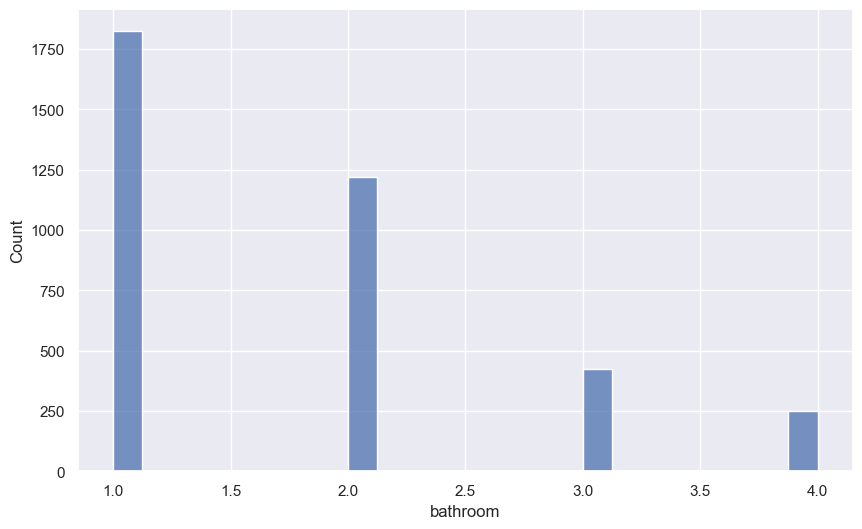

In [13]:
sns.histplot(df.bathroom);

## 2.2 Price

In [14]:
min_price = np.percentile(df.price, 0.02)
max_price = np.percentile(df.price, 99.1)
print(f'Min_price: {min_price}, Max_price: {max_price}')

Min_price: 57.43, Max_price: 24237.500000000407


In [15]:
df = remove_outlier(df, 'price', min_price, max_price)

## 2.3 Metric

In [16]:
min_metric = np.percentile(df.metric, 0.02)
max_metric = np.percentile(df.metric, 99.9)
print(f'Min_price: {min_metric}, Max_price: {max_metric}')

Min_price: 1.0, Max_price: 2862.5600000010872


In [17]:
df = remove_outlier(df, 'metric', min_metric, max_metric)

In [18]:
df.head()

,price,energy_certify,metric,description,location,rooms,company,property_type,district,bathroom,condition
0,900,E,124.000,Andar de Moradia T3| Arrendamento| Cacia,"Cacia, Aveiro",3,Zome Viva Aveiro,moradia,Aveiro,2.000,Usado
1,2000,D,147.000,Moradia T4 para arrendamento na praia de Corte...,"Cortegaça, Ovar, Aveiro",4,A Casa é Sua,moradia,Aveiro,4.000,Usado
2,5000,F,300.000,Moradia T2 para arrendamento,"Mozelos, Santa Maria da Feira, Aveiro",2,RE/MAX + Grupo Vantagem,moradia,Aveiro,1.000,None
3,900,E,108.000,"Moradia V3, condomínio privado, para arrendar ...","Santa Maria da Feira, Travanca, Sanfins e Espa...",3,Chave Nova - S.M.Feira,moradia,Aveiro,3.000,Usado
4,1200,E,134.000,Moradia V4 no centro da Feira,"Santa Maria da Feira, Travanca, Sanfins e Espa...",4,Imo2007,moradia,Aveiro,2.000,Usado


# 2.4 condition

In [19]:
df.condition = df.condition.fillna('Usado')

## 2.5 Rooms

In [67]:
# to_drop = df[(df.rooms == 0) & (df.bathroom > 1)].index
# train.drop(to_drop,inplace=True)

In [26]:
T = ['T1','T2','T3','T4','T5','T6']
for t in T:
    indexs = df[(df.rooms == 0) & (df.description.str.contains(t))].index
    df.loc[indexs, 'rooms'] = int(t.replace('T', ''))

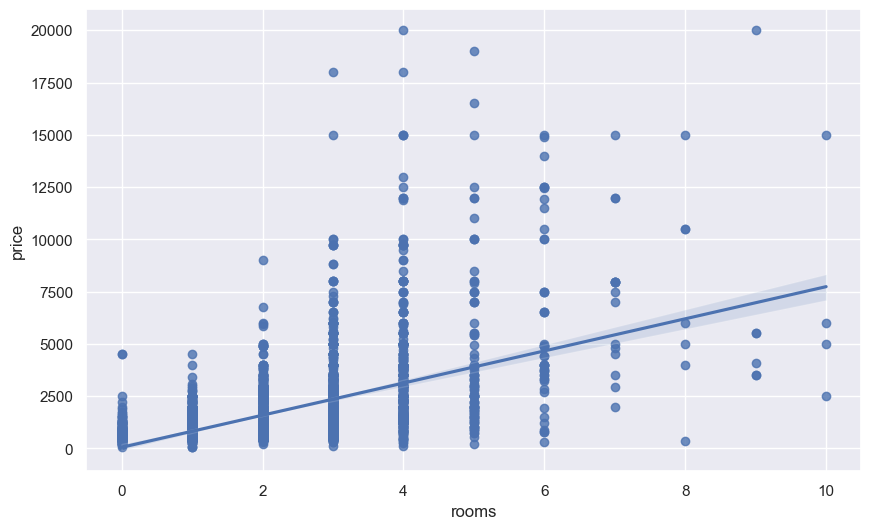

In [27]:
# Create a distplot
sns.regplot(x='rooms',
             y='price',
             data=df)

# Display the plot
plt.show()

<Axes: ylabel='rooms'>

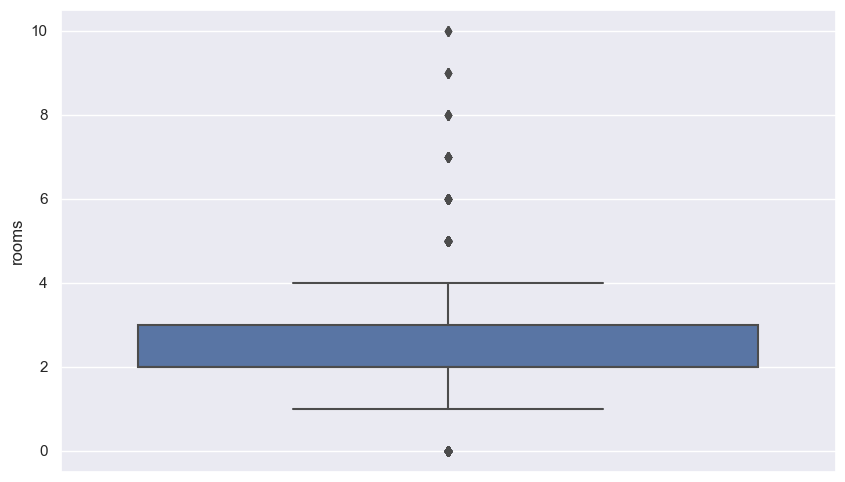

In [28]:
sns.boxplot(df, y='rooms')

In [29]:
min_rooms = np.percentile(df.rooms, 0.02)
max_rooms = np.percentile(df.rooms, 99)
print(f'min_rooms: {min_rooms}, max_rooms: {max_rooms}')



min_rooms: 0.0, max_rooms: 6.0


In [30]:
df = remove_outlier(df, 'rooms', min_rooms, max_rooms)

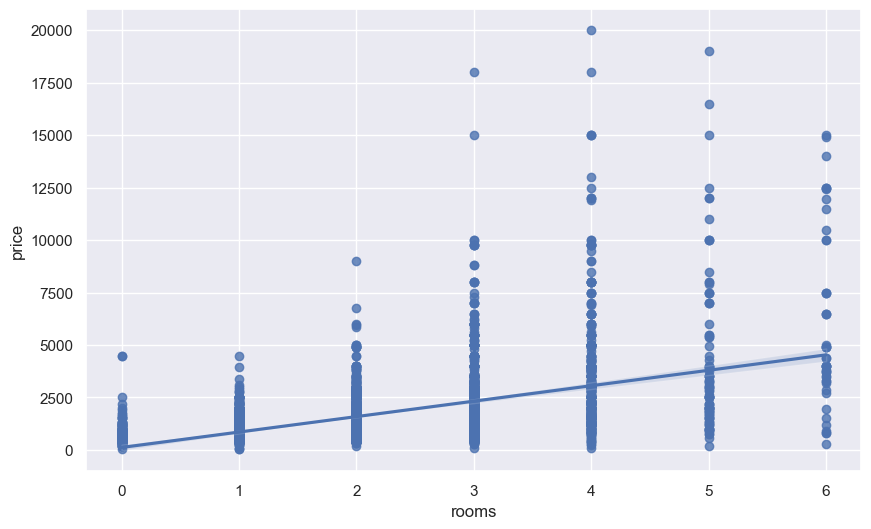

In [31]:
# Create a distplot
sns.regplot(x='rooms',
             y='price',
             data=df)

# Display the plot
plt.show()

# Save Train Data

In [32]:
assert df.isna().sum().sum() == 0

df.to_parquet('../data/processed/data.parquet')

# Val

In [25]:
val.head()

,price,energy_certify,metric,description,location,rooms,company,property_type,district,bathroom,condition
4130,1600,B-,113.000,Apartamento T2 em Miraflores com dois lugares ...,"Algés, Linda-a-Velha e Cruz Quebrada-Dafundo, ...",2,KW Lead1,apartamento,Lisboa,2.000,None
4720,1850,B-,146.000,Apartamento T3 - Varanda - Vista de rio - Luga...,"Moscavide e Portela, Loures, Lisboa",3,Anúncio Particular,apartamento,Lisboa,2.000,Renovado
1563,5950,C,160.000,"Penthouse T3 Monte Estoril, Cascais.","Cascais e Estoril, Cascais, Lisboa",3,La Vita - Homes -,apartamento,Lisboa,2.000,Usado
4798,2200,B,80.000,T2 Duplex no condomínio Metrocity,"Parque das Nações, Lisboa",2,Sucessos Confiantes,apartamento,Lisboa,2.000,Usado
652,1200,D,119.400,"APARTAMENTO T3 PARA ARRENDAMENTO, LAMAÇÃES","Nogueira, Fraião e Lamaçães, Braga",3,PREDIMED PORTUGAL,apartamento,Braga,NaN,None


In [26]:
val.isna().sum()

price               0
energy_certify      0
metric              0
description         0
location            0
rooms               0
company             0
property_type       0
district            0
bathroom          129
condition         298
dtype: int64

In [27]:
val.condition = val.condition.fillna('Usado')
val.bathroom = val.bathroom.fillna(1)

In [28]:
val.describe()

,price,metric,rooms,bathroom
count,1121.000,1121.000,1121.000,1121.000
mean,4453.154,122.181,2.475,1.947
std,34290.118,152.166,1.369,2.131
min,60.000,1.000,0.000,1.000
25%,900.000,70.000,2.000,1.000
50%,1350.000,96.400,2.000,2.000
75%,2200.000,140.000,3.000,2.000
max,770000.000,4058.000,10.000,42.000


# Save Val Data

In [29]:
assert val.isna().sum().sum() == 0

val.to_parquet('../data/processed/val.parquet')

# Split data 

In [6]:
# Generate val_data
train, val = train_test_split(df,  test_size=.3, train_size=.7, random_state=42)

In [7]:
print(f'Train: {train.shape[0]}\nVal: {val.shape[0]}')

Train: 2615
Val: 1121
